In [1]:
import networkx as nx
import pandas as pd
import surprise
import numpy as np
import seaborn as sns
import itertools

In [2]:
from tqdm import tqdm

# Aplicando predição de links de redes complexas ao domínio de filtragem colaborativa em sistemas de recomendação


Nome: CAio Túlio de Deus Andrade
NUSP: 9797232

## Funções úteis

In [3]:
def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [4]:
def measures(G):
    def momment_of_degree_distribution(G,m):
        M = 0
        N = len(G)
        for i in G.nodes:
            M = M + G.degree(i)**m
        M = M/N
        return M

    N = len(G)
    M = G.number_of_edges()
    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)
    k1 = momment_of_degree_distribution(G,1)
    k2 = momment_of_degree_distribution(G,2)
    variance = momment_of_degree_distribution(G,2) - momment_of_degree_distribution(G,1)**2
    av_cl = nx.average_clustering(G)
    global_cl = nx.transitivity(G)
    l = nx.average_shortest_path_length(G)
    r=nx.degree_assortativity_coefficient(G)

    return  k1,k2,variance,av_cl, global_cl, l,r

### Carregando os dados

In [5]:
#!wget -P ./data "https://files.grouplens.org/datasets/movielens/ml-100k.zip"

In [6]:
#!cd ./data && unzip "ml-100k.zip"

In [7]:
df = pd.read_csv("data/ml-100k/u.data", sep="\t", header=None)
df.columns = ["user", "item", "rating", "timestamp"]

In [8]:
df

user  item  rating  timestamp
0       196   242       3  881250949
1       186   302       3  891717742
2        22   377       1  878887116
3       244    51       2  880606923
4       166   346       1  886397596
...     ...   ...     ...        ...
99995   880   476       3  880175444
99996   716   204       5  879795543
99997   276  1090       1  874795795
99998    13   225       2  882399156
99999    12   203       3  879959583

[100000 rows x 4 columns]

## Criando uma rede complexa a partir da matriz de avaliações


df é uma versão enxuta de uma matriz de avaliações de itens. Para transformar em uma rede complexa, precisamos:

1. Definir quais itens cada usuário avaliou, e suas notas
2. Definir qual a similaridade mediana entre usuários na base de dados
3. Criar conexões entre os usuários que estão acima da mediana

TODO: editar essa parte da mediana. Acho que não vai ser tão simples assim, e talvez faca sentido verificar qual similaridade mínima permite um nível legal de performance.


In [9]:
df

user  item  rating  timestamp
0       196   242       3  881250949
1       186   302       3  891717742
2        22   377       1  878887116
3       244    51       2  880606923
4       166   346       1  886397596
...     ...   ...     ...        ...
99995   880   476       3  880175444
99996   716   204       5  879795543
99997   276  1090       1  874795795
99998    13   225       2  882399156
99999    12   203       3  879959583

[100000 rows x 4 columns]

In [10]:
rating_matrix = df.groupby("user").agg({"rating": list, "item": list})
rating_matrix["n_rated"] = rating_matrix["rating"].apply(lambda r: len(r))
rating_matrix["mean_centered_ratings"] = rating_matrix["rating"].apply(lambda rating_list:
                                                                       [rating - np.mean(rating_list) for rating in rating_list])
rating_matrix["rating2item"] = rating_matrix.apply(lambda row: dict(zip(row["item"], row["mean_centered_ratings"])), axis=1)



In [11]:
rating_matrix

rating  \
user                                                      
1     [4, 3, 4, 4, 4, 5, 5, 4, 2, 3, 4, 4, 5, 5, 4, ...   
2     [4, 5, 5, 1, 4, 3, 3, 3, 4, 3, 4, 3, 3, 4, 5, ...   
3     [1, 1, 1, 3, 2, 4, 2, 1, 5, 3, 3, 1, 4, 2, 3, ...   
4     [3, 5, 5, 4, 4, 3, 5, 4, 5, 5, 4, 5, 3, 5, 3, ...   
5     [3, 4, 1, 2, 1, 1, 1, 4, 3, 3, 3, 4, 5, 2, 4, ...   
...                                                 ...   
939   [2, 3, 4, 4, 5, 5, 4, 5, 5, 4, 5, 4, 5, 3, 2, ...   
940   [3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 5, 5, 4, 3, 5, ...   
941   [4, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 2, 2, 3, 5, ...   
942   [4, 4, 4, 5, 4, 5, 4, 3, 3, 4, 5, 3, 3, 2, 4, ...   
943   [4, 4, 4, 1, 4, 2, 4, 4, 5, 5, 2, 4, 4, 5, 4, ...   

                                                   item  n_rated  \
user                                                               
1     [61, 189, 33, 160, 20, 202, 171, 265, 155, 117...      272   
2     [292, 251, 50, 314, 297, 290, 312, 281, 13, 28...       62   
3     [335, 245, 337, 343, 323, 331, 294, 332, 328, ...       54   
4     [264, 303, 361, 357, 260, 356, 294, 288, 50, 3...       24   
5     [2, 17, 439, 225, 110, 454, 424, 1, 363, 98, 1...      175   
...                                                 ...      ...   
939   [931, 106, 258, 1054, 689, 476, 409, 121, 1190...       49   
940   [193, 568, 14, 205, 272, 655, 315, 66, 873, 28...      107   
941   [147, 124, 117, 181, 993, 258, 7, 475, 257, 15...       22   
942   [117, 200, 604, 423, 261, 427, 487, 323, 615, ...       79   
943   [58, 111, 11, 570, 232, 1067, 808, 356, 186, 2...      168   

                                  mean_centered_ratings  \
user                                                      
1     [0.3897058823529411, -0.6102941176470589, 0.38...   
2     [0.2903225806451615, 1.2903225806451615, 1.290...   
3     [-1.7962962962962963, -1.7962962962962963, -1....   
4     [-1.333333333333333, 0.666666666666667, 0.6666...   
5     [0.1257142857142859, 1.125714285714286, -1.874...   
...                                                 ...   
939   [-2.2653061224489797, -1.2653061224489797, -0....   
940   [-0.457943925233645, -0.457943925233645, -0.45...   
941   [-0.04545454545454586, 0.9545454545454541, 0.9...   
942   [-0.2658227848101262, -0.2658227848101262, -0....   
943   [0.5892857142857144, 0.5892857142857144, 0.589...   

                                            rating2item  
user                                                     
1     {61: 0.3897058823529411, 189: -0.6102941176470...  
2     {292: 0.2903225806451615, 251: 1.2903225806451...  
3     {335: -1.7962962962962963, 245: -1.79629629629...  
4     {264: -1.333333333333333, 303: 0.6666666666666...  
5     {2: 0.1257142857142859, 17: 1.125714285714286,...  
...                                                 ...  
939   {931: -2.2653061224489797, 106: -1.26530612244...  
940   {193: -0.457943925233645, 568: -0.457943925233...  
941   {147: -0.04545454545454586, 124: 0.95454545454...  
942   {117: -0.2658227848101262, 200: -0.26582278481...  
943   {58: 0.5892857142857144, 111: 0.58928571428571...  

[943 rows x 5 columns]

In [12]:
def preprocess_network(net):
    """
    Given a network `net`, convert to undirected,
    set node labels to range [0,..., n], remove
    self loops and mantains only the largest
    component
    """
    Gcc = sorted(nx.connected_components(net), key=len, reverse=True)
    G = net.subgraph(Gcc[0]).to_undirected()
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    G.remove_edges_from(nx.selfloop_edges(G))

    return G

In [13]:
def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return pd.DataFrame({'k': kvalues, 'p(k)': Pk})


In [14]:
def get_items_rated_in_common(user1, user2, df):
    rated_by_user1 = set(df.loc[user1]['item'])
    rated_by_user2 = set(df.loc[user2]['item'])

    return sorted(list(rated_by_user1.intersection(rated_by_user2)))


In [15]:
def get_ratings(user, df, items):
    ratings_map_user1 = df.loc[user]['rating2item']
    return [ratings_map_user1[i] for i in items]

In [16]:
def get_similarity(user1, user2, df):
    commonly_rated = get_items_rated_in_common(user1, user2, df)
    if not commonly_rated:
        return 0.0
    ratings_1 = np.array(get_ratings(user1, df, commonly_rated))
    ratings_2 = np.array(get_ratings(user2, df, commonly_rated))
    return cosine_sim(ratings_1, ratings_2)


In [17]:
def compute_similarity_matrix(rating_matrix):
    n_users = len(rating_matrix)
    sim_matrix = []
    for i in range(1, n_users):
        for j in range(i+1, n_users):
            sim = get_similarity(i, j, rating_matrix)
            row = [i, j, sim]
            sim_matrix.append(row)
    return pd.DataFrame(sim_matrix, columns=['user1', 'user2', 'similarity'])

In [18]:
%%time
sim_matrix = compute_similarity_matrix(rating_matrix)

/tmp/ipykernel_3960/3678999531.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


CPU times: user 30.8 s, sys: 29.3 ms, total: 30.9 s
Wall time: 30.9 s


In [19]:
def create_network_from_sim_matrix(sim_matrix, threshold=0.5):
    cutoff = sim_matrix.similarity.quantile(threshold)
    pairs_with_edge = sim_matrix[sim_matrix['similarity'] > cutoff][["user1", "user2", "similarity"]]
    G = nx.Graph()
    G.add_edges_from(pairs_with_edge[['user1', 'user2']].values)

    return G

In [20]:
G = create_network_from_sim_matrix(sim_matrix)

In [21]:
for u, v in G.edges():
    print(f"{u} -> {v}")

1 -> 2
1 -> 3
1 -> 4
1 -> 5
1 -> 6
1 -> 7
1 -> 8
1 -> 9
1 -> 11
1 -> 13
1 -> 15
1 -> 16
1 -> 17
1 -> 21
1 -> 22
1 -> 23
1 -> 25
1 -> 26
1 -> 27
1 -> 28
1 -> 29
1 -> 30
1 -> 32
1 -> 34
1 -> 37
1 -> 39
1 -> 40
1 -> 41
1 -> 42
1 -> 43
1 -> 44
1 -> 45
1 -> 46
1 -> 47
1 -> 48
1 -> 51
1 -> 53
1 -> 54
1 -> 55
1 -> 56
1 -> 57
1 -> 58
1 -> 59
1 -> 60
1 -> 61
1 -> 62
1 -> 63
1 -> 64
1 -> 65
1 -> 66
1 -> 68
1 -> 69
1 -> 70
1 -> 73
1 -> 75
1 -> 76
1 -> 77
1 -> 80
1 -> 82
1 -> 83
1 -> 85
1 -> 86
1 -> 87
1 -> 91
1 -> 92
1 -> 93
1 -> 94
1 -> 95
1 -> 97
1 -> 99
1 -> 100
1 -> 102
1 -> 104
1 -> 105
1 -> 107
1 -> 108
1 -> 109
1 -> 111
1 -> 114
1 -> 115
1 -> 116
1 -> 117
1 -> 118
1 -> 119
1 -> 120
1 -> 121
1 -> 122
1 -> 123
1 -> 125
1 -> 129
1 -> 130
1 -> 133
1 -> 134
1 -> 135
1 -> 136
1 -> 137
1 -> 139
1 -> 140
1 -> 142
1 -> 144
1 -> 145
1 -> 148
1 -> 149
1 -> 151
1 -> 154
1 -> 155
1 -> 156
1 -> 157
1 -> 158
1 -> 159
1 -> 160
1 -> 162
1 -> 164
1 -> 165
1 -> 166
1 -> 168
1 -> 169
1 -> 171
1 -> 172
1 -> 17

In [22]:
quantiles = list(np.arange(0.5, 1.0, 0.1) ) + [0.95, 0.99]

In [23]:
quantiles

[0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 0.95, 0.99]

In [24]:
len(G.edges)

221145

In [25]:
%%time
rows = []

for q in quantiles:
    G = create_network_from_sim_matrix(sim_matrix, threshold=q)
    n_components = nx.number_connected_components(G)
    if (n_components > 1):
        G = preprocess_network(G)
    E = len(G.edges)
    avg_degree, second_moment, variance, avg_clustering, global_clustering, avg_shortest_path, assortativity = measures(G)
    
    rows.append([
        q, avg_degree, second_moment, variance,
        avg_clustering, global_clustering, avg_shortest_path, assortativity, n_components, E
    ])

measures_df = pd.DataFrame(rows, columns=[
    "threshold", "avg_degree", "second_moment", "variance",
    "avg_clustering", "global_clustering", "avg_shortest_path", "assortativity", "n_components", "n_edges"
])


CPU times: user 60 s, sys: 32.3 ms, total: 1min
Wall time: 1min


In [26]:
measures_df

threshold  avg_degree  second_moment     variance  avg_clustering  \
0       0.50  469.522293  229999.579618  9548.396000        0.564397   
1       0.60  375.617834  148883.647558  7794.890043        0.473377   
2       0.70  281.713376   86021.522293  6659.096191        0.386341   
3       0.80  187.808917   40875.095541  5602.906163        0.301123   
4       0.90   93.904459   12045.358811  3227.311466        0.197810   
5       0.95   48.128400    3756.028292  1439.685363        0.103136   
6       0.99    2.208092       8.323699     3.448027        0.000000   

   global_clustering  avg_shortest_path  assortativity  n_components  n_edges  
0           0.570423           1.501039       0.113085             1   221145  
1           0.478658           1.600831       0.104890             1   176916  
2           0.383921           1.700623       0.011197             1   132687  
3           0.283193           1.800458      -0.124222             1    88458  
4           0.165767           1.933370      -0.249340             1    44229  
5           0.087314           2.211429      -0.301388             1    22115  
6           0.000000           7.361204      -0.270913            48      191

In [27]:
G = create_network_from_sim_matrix(sim_matrix, threshold=0.95)

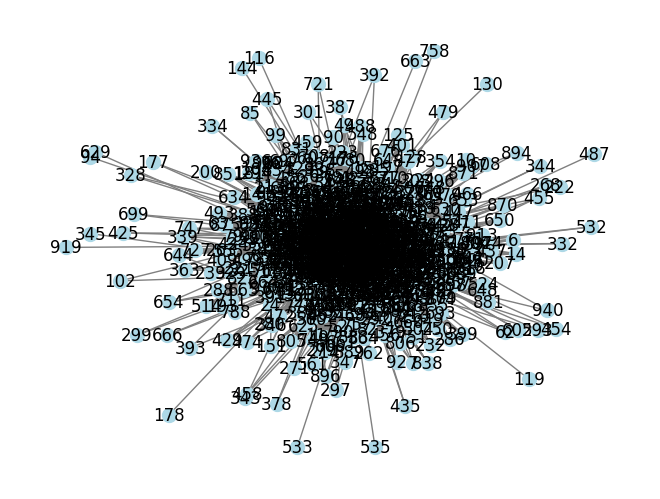

In [28]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=100)
plt.show()

In [29]:
df_p_k = degree_distribution(G)

In [30]:
df_p_k

k      p(k)
0      0  0.000000
1      1  0.015234
2      2  0.033732
3      3  0.008705
4      4  0.014146
..   ...       ...
201  201  0.000000
202  202  0.000000
203  203  0.000000
204  204  0.000000
205  205  0.001088

[206 rows x 2 columns]

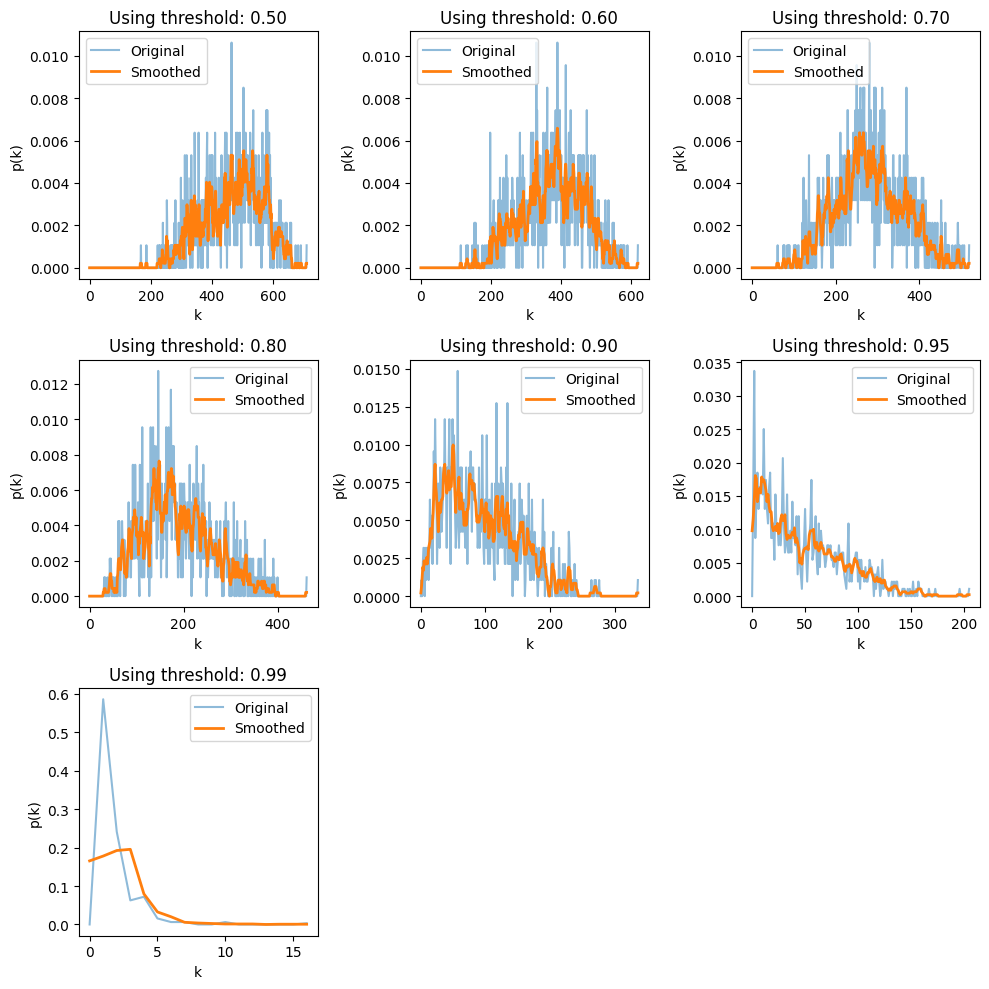

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
window_size = 5

axes = axes.flatten()

for idx, i in enumerate(quantiles):
    G = create_network_from_sim_matrix(sim_matrix, threshold=i)
    df_p_k = degree_distribution(G)

    p_k = df_p_k['p(k)'].values
    p_k_smooth = np.convolve(p_k, np.ones(window_size)/window_size, mode='same')
    ax = axes[idx]
    ax.set_title(f"Using threshold: {i:.2f}")

    ax.plot(df_p_k['k'], p_k, label='Original', alpha=0.5)
    ax.plot(df_p_k['k'], p_k_smooth, label='Smoothed', linewidth=2)
    ax.set_xlabel('k')
    ax.set_ylabel('p(k)')
    ax.legend()

for j in range(len(quantiles), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

É interesasnte notar que conforme aumentamos o limiar de similaridade entre usuários, a distribuição de grau da rede passa a assumir um formato mais próximo a uma distribuição de potencia, ao invés de uma curva similar a uma normal, com limiares menores que 0.9; Essa constatacão pode ser interessante para sistemas de recomendação com usuários novos: podemos usar uma rede erdos renii ou Barabasi albert (Dependendo do limiar escolhido) para simular as preferencias de usuários novos.

## Implementando medidas de predição de links

In [32]:
def common_neighbors(G, a,b):
    neighbors_a = set(G.neighbors(a))
    neighbors_b = set(G.neighbors(b))

    return len(neighbors_a.intersection(neighbors_b))

In [33]:
def sorensen_index(G, a, b):
    neighbors_a = set(G.neighbors(a))
    neighbors_b = set(G.neighbors(b))

    inter = len(neighbors_a.intersection(neighbors_b))

    return (2 * inter) / (len(neighbors_a) + len(neighbors_b))

In [34]:
def hub_promoter_index(G, a, b):
    neighbors_a = set(G.neighbors(a))
    neighbors_b = set(G.neighbors(b))

    inter = len(neighbors_a.intersection(neighbors_b))

    return inter / (min(len(neighbors_a), len(neighbors_b)))

In [35]:
def hub_demoter_index(G, a, b):
    neighbors_a = set(G.neighbors(a))
    neighbors_b = set(G.neighbors(b))

    inter = len(neighbors_a.intersection(neighbors_b))

    return inter / (max(len(neighbors_a), len(neighbors_b)))

In [36]:
def preferential_attachment_index(G, a, b):
    neighbors_a = set(G.neighbors(a))
    neighbors_b = set(G.neighbors(b))


    return len(neighbors_a) * len(neighbors_b)

In [37]:
def neg_shortest_path(G, a, b):
    return -len(nx.shortest_path(G, source=a, target=b))

## Computando similaridades de acordo com as diferentes medidas de predição de link

In [38]:
G = create_network_from_sim_matrix(sim_matrix, threshold=0.95)

In [39]:
similarities = {
    "common_neighbors": common_neighbors,
    "sorensen_index": sorensen_index,
    "hub_promoter_index": hub_promoter_index,
    "preferential_attachment_index": preferential_attachment_index,
    "neg_shortest_path": neg_shortest_path
}

In [40]:
def compute_similarity_matrix_from_link_prediction(network, similarities_map):
    sim_matrix = []
    for i, j in itertools.combinations(network.nodes, 2):
        row = [i, j]
        sims = []
        for func_name, func in similarities_map.items():
            sims.append(func(network, i, j))
        sim_matrix.append(row + sims)
        sim_matrix.append([j,i] + sims)
    similarities_columns = list(similarities.keys())
    cols = ['user1', 'user2']
    cols.extend(similarities_columns)
    return pd.DataFrame(sim_matrix, columns=cols)

In [41]:
similarities_df = compute_similarity_matrix_from_link_prediction(G, similarities)

In [42]:
similarities_df

user1  user2  common_neighbors  sorensen_index  hub_promoter_index  \
0           1     34                 0             0.0                 0.0   
1          34      1                 0             0.0                 0.0   
2           1    105                 0             0.0                 0.0   
3         105      1                 0             0.0                 0.0   
4           1    111                 0             0.0                 0.0   
...       ...    ...               ...             ...                 ...   
843637    727    666                 0             0.0                 0.0   
843638    666    747                 0             0.0                 0.0   
843639    747    666                 0             0.0                 0.0   
843640    727    747                 0             0.0                 0.0   
843641    747    727                 0             0.0                 0.0   

        preferential_attachment_index  neg_shortest_path  
0                                2249                 -2  
1                                2249                 -2  
2                                1716                 -2  
3                                1716                 -2  
4                                1859                 -2  
...                               ...                ...  
843637                              8                 -5  
843638                              6                 -5  
843639                              6                 -5  
843640                             12                 -5  
843641                             12                 -5  

[843642 rows x 7 columns]

In [43]:
similarities_df[["common_neighbors", "sorensen_index","hub_promoter_index", "preferential_attachment_index", "neg_shortest_path"]].corr()

common_neighbors  sorensen_index  \
common_neighbors                       1.000000        0.830230   
sorensen_index                         0.830230        1.000000   
hub_promoter_index                     0.465938        0.639708   
preferential_attachment_index          0.746567        0.426942   
neg_shortest_path                      0.401732        0.482558   

                               hub_promoter_index  \
common_neighbors                         0.465938   
sorensen_index                           0.639708   
hub_promoter_index                       1.000000   
preferential_attachment_index            0.116569   
neg_shortest_path                        0.453373   

                               preferential_attachment_index  \
common_neighbors                                    0.746567   
sorensen_index                                      0.426942   
hub_promoter_index                                  0.116569   
preferential_attachment_index                       1.000000   
neg_shortest_path                                   0.413782   

                               neg_shortest_path  
common_neighbors                        0.401732  
sorensen_index                          0.482558  
hub_promoter_index                      0.453373  
preferential_attachment_index           0.413782  
neg_shortest_path                       1.000000

## Prever a avaliação de itens usando técnicas de predição de links


Vamos realizar uma filtragem colaborativa baseada em usuários utilizando técnicas de predição de links

In [44]:
def user_history(user, ratings):
    # Retorna as avaliações realizadas pelo usuário
    return ratings[ratings["user"] == user]

In [45]:
def get_user_rating_of_item(user, item, ratings):
    user_ratings = user_history(user, ratings)
    return user_ratings[user_ratings["item"] == item].rating.item()

In [46]:
def get_users_that_rated_item(item, ratings):
    rated_item = ratings[ratings["item"] == item]
    return rated_item.user.unique().tolist()

In [47]:
def get_k_most_similar_users_to_u_that_rated_item_j(u, j, sim_function, similarities_matrix, ratings, k=20):
    """
        Dado um usuário u e um item j, retorna os k usuários mais similares a u que também avaliaram o item j.
        Os usuários mais similares são obtidos consultando o dataframe similarities_matrix, pela coluna sim_funcion.

        Entrada:
            - u (int): Usuario
            - j (int): Item
            - sim_function (string): Função de similaridade a ser usada. Deve estar presente no dicionário similarities.
            - similarities_matrix (pd.DataFrame): matriz de similaridade entre pares de usuário, utilizando diversas
                metricas de similaridades
            - ratings (pd.DataFrame): dataframe contendo a avaliação dos usuários a itens
            - k (int, opcional): número de usuários similares a serem considerados.
        Saída:
            * most_similar_users (list[int]) lista dos no maximo k usuarios mais similares a u que também
            avaliaram o item j
    """
    similar_users_to_u = similarities_matrix[similarities_matrix["user1"] == u]
    users_that_rated_j = get_users_that_rated_item(j, ratings)

    similar_to_u_that_rated_j = similar_users_to_u["user2"].isin(users_that_rated_j)
    filtered_similar_users = similar_users_to_u[similar_to_u_that_rated_j]
    u_k_most_similar = filtered_similar_users.sort_values(by=sim_function, ascending=False).iloc[:k]
    most_similar_users = u_k_most_similar.user2.tolist()

    return most_similar_users

In [48]:
def predict_rating(u, j, user2ratingbias, sim_function, similarities_matrix, ratings, k=20):
    """
        Preve a avaliação que o usuário u daria ao item j utilizando os k
        usuários mais similares a u. Definimos os k usuários mais similares
        a u por meio da matriz de similaridades similarities_matrix e a função
        sim_function; Usamos um dicionario (user2ratingbias) contendo o viés de 
        avaliação do usuário u e de seus vizinhos
    """


    u_k_most_similar = get_k_most_similar_users_to_u_that_rated_item_j(u, j, sim_function, similarities_matrix, ratings, k)

    is_user_u = user2ratingbias["user"] == u
    r_u_mean = user2ratingbias[is_user_u].mean_rating.item()
    numerator = 0
    denominator = 0
    for i in u_k_most_similar:
        r_i_j = get_user_rating_of_item(i, j, ratings)
        r_i_mean = user2ratingbias[user2ratingbias["user"] == i].mean_rating.item()
        sim_u_i = similarities_matrix[(similarities_matrix["user1"] == u) & (similarities_matrix["user2"] == i)][sim_function].item()
        numerator += sim_u_i * (r_i_j - r_i_mean)
        denominator += abs(sim_u_i)
    if (denominator > 0):
        return r_u_mean + numerator/denominator
    else:
        return r_u_mean
        

    

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

In [50]:
def compute_user_cosine_similarity(ratings_df):
    user_item = ratings_df.pivot(index='user', columns='item', values='rating').fillna(0)

    sim_matrix = cosine_similarity(user_item)

    user_ids = user_item.index
    sim_df = pd.DataFrame(sim_matrix, index=user_ids, columns=user_ids)

    sim_long = sim_df.reset_index().melt(id_vars='user', var_name='user2', value_name='cosine_similarity')
    sim_long = sim_long.rename(columns={'user': 'user1'})

    return sim_long

In [51]:
cos_sim = compute_user_cosine_similarity(df)

In [52]:
cos_sim

user1 user2  cosine_similarity
0           1     1           1.000000
1           2     1           0.166931
2           3     1           0.047460
3           4     1           0.064358
4           5     1           0.378475
...       ...   ...                ...
889244    939   943           0.144250
889245    940   943           0.241028
889246    941   943           0.095120
889247    942   943           0.182465
889248    943   943           1.000000

[889249 rows x 3 columns]

In [67]:
def score_user_item_baseline(u, j, user_mean_rating, ratings_dict, sim_dict, df, k=20):
    users_rated_j = df[df["item"] == j]["user"].unique()
    similarities = [
        (v, sim_dict.get(u, {}).get(v, 0))
        for v in users_rated_j if v != u and sim_dict.get(u, {}).get(v, 0) != 0
    ]
    top_k = sorted(similarities, key=lambda x: -abs(x[1]))[:k]

    numerator, denominator = 0.0, 0.0
    for v, sim in top_k:
        r_vj = ratings_dict.get((v, j), None)
        if r_vj is None:
            continue
        r_v_mean = user_mean_rating[v]
        numerator += sim * (r_vj - r_v_mean)
        denominator += abs(sim)

    r_u_mean = user_mean_rating[u]
    return r_u_mean + numerator / denominator if denominator > 0 else r_u_mean

def score_dataset_with_baseline(df, cos_sim_matrix):
    user_mean_rating = dict(df.groupby("user")["rating"].mean())
    ratings_dict = dict(zip(zip(df["user"], df["item"]), df["rating"]))
    sim_dict = cos_sim_matrix.groupby("user1").apply(
        lambda g: dict(zip(g["user2"], g["cosine_similarity"]))
    ).to_dict()

    predictions = [
        (u, j, score_user_item_baseline(u, j, user_mean_rating, ratings_dict, sim_dict, df))
        for u, j in zip(df["user"], df["item"])
    ]

    return pd.DataFrame(predictions, columns=["user", "item", "predicted_rating"])


In [68]:
%%time
predictions_cossine = score_dataset_with_baseline(df, cos_sim)

/tmp/ipykernel_3960/4252025528.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sim_dict = cos_sim_matrix.groupby("user1").apply(


CPU times: user 19 s, sys: 19 ms, total: 19 s
Wall time: 19 s


In [69]:
predictions_cossine

user  item  predicted_rating
0       196   242          4.368423
1       186   302          4.117228
2        22   377          2.265959
3       244    51          3.935599
4       166   346          3.381078
...     ...   ...               ...
99995   880   476          2.733944
99996   716   204          4.157086
99997   276  1090          2.545615
99998    13   225          2.182219
99999    12   203          4.594131

[100000 rows x 3 columns]

In [56]:
similarities_df

user1  user2  common_neighbors  sorensen_index  hub_promoter_index  \
0           1     34                 0             0.0                 0.0   
1          34      1                 0             0.0                 0.0   
2           1    105                 0             0.0                 0.0   
3         105      1                 0             0.0                 0.0   
4           1    111                 0             0.0                 0.0   
...       ...    ...               ...             ...                 ...   
843637    727    666                 0             0.0                 0.0   
843638    666    747                 0             0.0                 0.0   
843639    747    666                 0             0.0                 0.0   
843640    727    747                 0             0.0                 0.0   
843641    747    727                 0             0.0                 0.0   

        preferential_attachment_index  neg_shortest_path  
0                                2249                 -2  
1                                2249                 -2  
2                                1716                 -2  
3                                1716                 -2  
4                                1859                 -2  
...                               ...                ...  
843637                              8                 -5  
843638                              6                 -5  
843639                              6                 -5  
843640                             12                 -5  
843641                             12                 -5  

[843642 rows x 7 columns]

In [57]:
similarities

{'common_neighbors': <function __main__.common_neighbors(G, a, b)>,
 'sorensen_index': <function __main__.sorensen_index(G, a, b)>,
 'hub_promoter_index': <function __main__.hub_promoter_index(G, a, b)>,
 'preferential_attachment_index': <function __main__.preferential_attachment_index(G, a, b)>,
 'neg_shortest_path': <function __main__.neg_shortest_path(G, a, b)>}

In [58]:
def evaluate(ratings, similarities, similarities_matrix, k=20):
    results = ratings[["user", "item", "rating"]].copy()
    user2ratingbias = ratings.groupby("user").agg({"rating": "mean"}).rename(columns={"rating": "mean_rating"}).reset_index()
    
    for sim_function in tqdm(similarities, desc="running similarities..."):
        results[f"{sim_function}_prediction"] = results.apply(lambda row: predict_rating(row["user"], row["item"], user2ratingbias, sim_function, similarities_matrix, df), axis=1)
        results["k"] = k
    return results

In [51]:
results_k_20 = evaluate(df, similarities.keys(), similarities_df)

running similarities...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [2:10:09<00:00, 1561.82s/it]


In [52]:
results_k_20

user  item  rating  common_neighbors_prediction   k  \
0       196   242       3                     4.217481  20   
1       186   302       3                     4.055836  20   
2        22   377       1                     2.477216  20   
3       244    51       2                     3.523968  20   
4       166   346       1                     3.964978  20   
...     ...   ...     ...                          ...  ..   
99995   880   476       3                     3.426630  20   
99996   716   204       5                     3.679051  20   
99997   276  1090       1                     3.465251  20   
99998    13   225       2                     3.097484  20   
99999    12   203       3                     4.419820  20   

       sorensen_index_prediction  hub_promoter_index_prediction  \
0                       4.250571                       3.964183   
1                       3.822720                       4.021140   
2                       2.489866                       2.672367   
3                       3.537628                       3.483004   
4                       3.893693                       3.981149   
...                          ...                            ...   
99995                   3.426630                       3.426630   
99996                   3.921256                       3.994192   
99997                   3.465251                       3.465251   
99998                   3.097484                       3.097484   
99999                   4.300918                       5.044119   

       preferential_attachment_index_prediction  neg_shortest_path_prediction  
0                                      4.347374                      3.209323  
1                                      4.249850                      2.790352  
2                                      2.381666                      4.331682  
3                                      3.339224                      3.559188  
4                                      3.746015                      3.192549  
...                                         ...                           ...  
99995                                  3.426630                      3.426630  
99996                                  3.444764                      3.337084  
99997                                  3.465251                      3.465251  
99998                                  3.097484                      3.097484  
99999                                  4.524088                      4.332835  

[100000 rows x 9 columns]

In [54]:
results_k_20.to_csv("data/predicted_ratings_by_methods.csv", index=False)

In [70]:
results_k_20 = pd.read_csv("data/predicted_ratings_by_methods.csv")

In [71]:
results_k_20

user  item  rating  common_neighbors_prediction   k  \
0       196   242       3                     4.217481  20   
1       186   302       3                     4.055836  20   
2        22   377       1                     2.477216  20   
3       244    51       2                     3.523968  20   
4       166   346       1                     3.964978  20   
...     ...   ...     ...                          ...  ..   
99995   880   476       3                     3.426630  20   
99996   716   204       5                     3.679051  20   
99997   276  1090       1                     3.465251  20   
99998    13   225       2                     3.097484  20   
99999    12   203       3                     4.419820  20   

       sorensen_index_prediction  hub_promoter_index_prediction  \
0                       4.250571                       3.964183   
1                       3.822720                       4.021140   
2                       2.489866                       2.672367   
3                       3.537628                       3.483004   
4                       3.893693                       3.981149   
...                          ...                            ...   
99995                   3.426630                       3.426630   
99996                   3.921256                       3.994192   
99997                   3.465251                       3.465251   
99998                   3.097484                       3.097484   
99999                   4.300918                       5.044119   

       preferential_attachment_index_prediction  neg_shortest_path_prediction  
0                                      4.347374                      3.209323  
1                                      4.249850                      2.790352  
2                                      2.381666                      4.331682  
3                                      3.339224                      3.559188  
4                                      3.746015                      3.192549  
...                                         ...                           ...  
99995                                  3.426630                      3.426630  
99996                                  3.444764                      3.337084  
99997                                  3.465251                      3.465251  
99998                                  3.097484                      3.097484  
99999                                  4.524088                      4.332835  

[100000 rows x 9 columns]

In [74]:
full_results = results_k_20.merge(predictions_cossine, on=["user", "item"]).rename(columns={"predicted_rating": "user_knn_cossine"})

In [75]:
full_results

user  item  rating  common_neighbors_prediction   k  \
0       196   242       3                     4.217481  20   
1       186   302       3                     4.055836  20   
2        22   377       1                     2.477216  20   
3       244    51       2                     3.523968  20   
4       166   346       1                     3.964978  20   
...     ...   ...     ...                          ...  ..   
99995   880   476       3                     3.426630  20   
99996   716   204       5                     3.679051  20   
99997   276  1090       1                     3.465251  20   
99998    13   225       2                     3.097484  20   
99999    12   203       3                     4.419820  20   

       sorensen_index_prediction  hub_promoter_index_prediction  \
0                       4.250571                       3.964183   
1                       3.822720                       4.021140   
2                       2.489866                       2.672367   
3                       3.537628                       3.483004   
4                       3.893693                       3.981149   
...                          ...                            ...   
99995                   3.426630                       3.426630   
99996                   3.921256                       3.994192   
99997                   3.465251                       3.465251   
99998                   3.097484                       3.097484   
99999                   4.300918                       5.044119   

       preferential_attachment_index_prediction  neg_shortest_path_prediction  \
0                                      4.347374                      3.209323   
1                                      4.249850                      2.790352   
2                                      2.381666                      4.331682   
3                                      3.339224                      3.559188   
4                                      3.746015                      3.192549   
...                                         ...                           ...   
99995                                  3.426630                      3.426630   
99996                                  3.444764                      3.337084   
99997                                  3.465251                      3.465251   
99998                                  3.097484                      3.097484   
99999                                  4.524088                      4.332835   

       user_knn_cossine  
0              4.368423  
1              4.117228  
2              2.265959  
3              3.935599  
4              3.381078  
...                 ...  
99995          2.733944  
99996          4.157086  
99997          2.545615  
99998          2.182219  
99999          4.594131  

[100000 rows x 10 columns]

## Medindo a performance das diferentes variantes

In [76]:
from sklearn.metrics import mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [78]:
metrics = [col for col in full_results.columns if col not in ["user", "item", "rating", "k"]]

In [79]:
metrics

['common_neighbors_prediction',
 'sorensen_index_prediction',
 'hub_promoter_index_prediction',
 'preferential_attachment_index_prediction',
 'neg_shortest_path_prediction',
 'user_knn_cossine']

/tmp/ipykernel_3960/2995966154.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


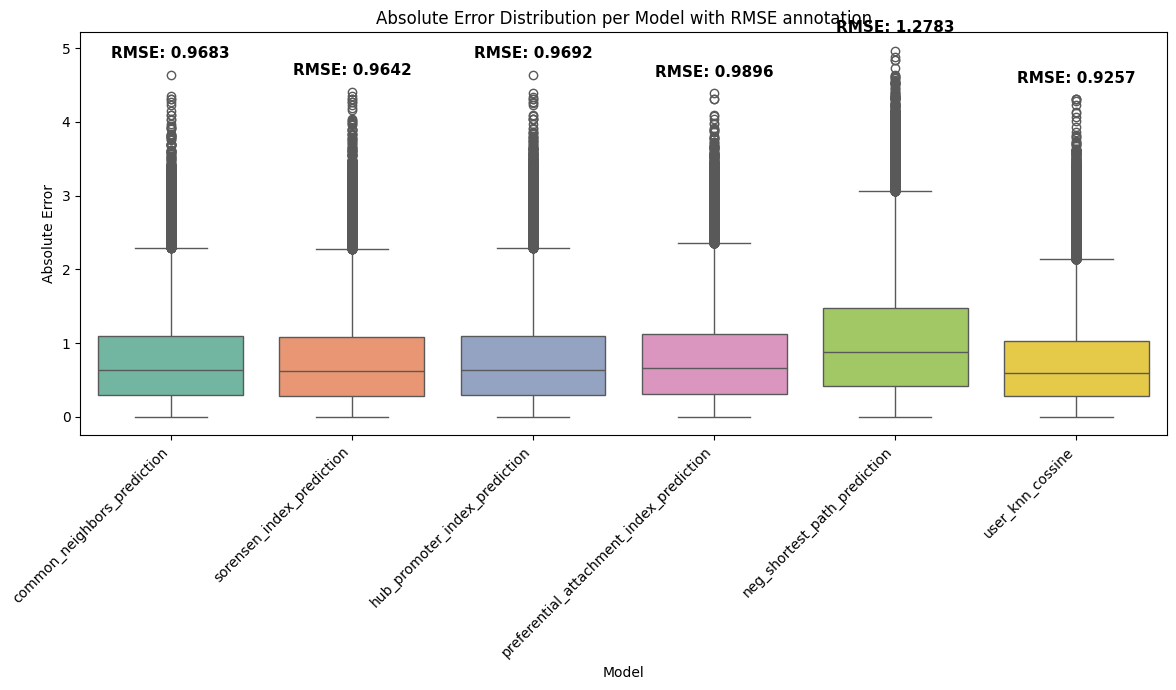

In [93]:

abs_error_data = []

metrics_dicts = {}

for m in metrics:
    y_true = full_results["rating"]
    y_pred = full_results[m]

    rmse_val = rmse(y_true, y_pred)
    metrics_dicts[m] = rmse_val

    abs_errors = np.abs(y_true - y_pred)
    abs_error_data.extend([(m, e) for e in abs_errors])

error_df = pd.DataFrame(abs_error_data, columns=["model", "abs_error"])

plt.figure(figsize=(12, 7))
ax = sns.boxplot(
    data=error_df,
    x="model",
    y="abs_error",
    hue="model",
    palette="Set2",
    dodge=False,
    legend=False,
)


ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

positions = range(len(metrics))
for pos, m in zip(positions, metrics):
    rmse_text = f"RMSE: {metrics_dicts[m]:.4f}"
    # y-position a bit above the max whisker
    y_max = error_df[error_df["model"] == m]["abs_error"].max()
    ax.text(pos, y_max * 1.05, rmse_text, ha='center', fontsize=11, fontweight='semibold')

plt.title("Absolute Error Distribution per Model with RMSE annotation")
plt.xlabel("Model")
plt.ylabel("Absolute Error")
plt.tight_layout()
plt.show()

In [82]:
metrics_dicts

{'common_neighbors_prediction': 0.9683252496147977,
 'sorensen_index_prediction': 0.9641800626898177,
 'hub_promoter_index_prediction': 0.9692396755925177,
 'preferential_attachment_index_prediction': 0.9895682340703127,
 'neg_shortest_path_prediction': 1.2782881919391693,
 'user_knn_cossine': 0.9257431328508529}

In [ ]:
predicted_df["abs_error"] = np.abs(df["rating"].values - predicted_df["predicted_rating"].values)

# Example: plot histogram of absolute errors
sns.histplot(predicted_df["abs_error"], bins=30, kde=True)